In [1]:
import sympy as sp
from sympy import *
from IPython.display import Math

sp.init_session()
sp.init_printing()

IPython console for SymPy 1.9 (Python 3.8.10-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.9/



### Selection of algorithm options:
- "$\text{div}(\boldsymbol{E})$ cleaning" using additional scalar field $F$
- "$\text{div}(\boldsymbol{B})$ cleaning" using additional scalar field $G$
- $\boldsymbol{J}$ constant, linear, or quadratic in time
- $\rho$ constant, linear, or quadratic in time

In [2]:
divE_cleaning = True # If False, F does not show up in the equations
divB_cleaning = True # If False, G does not show up in the equations
J_in_time = 'constant'
rho_in_time = 'constant'

### Auxiliary functions:

In [3]:
def check_diag(W, D, P, invP):
    """
    Check diagonalization of W as P*D*P**(-1).
    """
    Wd = P * D * invP
    for i in range(Wd.shape[0]):
        for j in range(Wd.shape[1]):
            Wd[i,j] = Wd[i,j].expand().simplify()
            diff = W[i,j] - Wd[i,j]
            diff = diff.expand().simplify()
            assert (diff == 0), f'Diagonalization failed: W[{i},{j}] - Wd[{i},{j}] = {diff} is not zero'

def simple_mat(W):
    """
    Simplify matrix W.
    """
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i,j] = W[i,j].expand().simplify()
            
def limit(f, x, l):
    """
    Compute limit of f at x=l.
    """
    lim = f.series(x, l, 1).removeO() - f.series(x, l, 0).removeO()
    lim = lim.simplify()
    return lim

### Definition of symbols:

In [4]:
dim = 6
if divE_cleaning:
    dim += 1
if divB_cleaning:
    dim += 1

c = sp.symbols(r'c', real=True, positive=True)
mu0 = sp.symbols(r'\mu_0', real=True, positive=True)

s = sp.symbols(r's', real=True, positive=True)
t = sp.symbols(r't', real=True, positive=True)
tn = sp.symbols(r't_n', real=True, positive=True)
dt = sp.symbols(r'\Delta{t}', real=True, positive=True)

# The assumption that kx, ky and kz are positive is general enough
# and makes it easier for SymPy to perform some of the calculations
kx = sp.symbols(r'k_x', real=True, positive=True)
ky = sp.symbols(r'k_y', real=True, positive=True)
kz = sp.symbols(r'k_z', real=True, positive=True)

Ex = sp.symbols(r'E^x')
Ey = sp.symbols(r'E^y')
Ez = sp.symbols(r'E^z')
E = Matrix([[Ex], [Ey], [Ez]])

Bx = sp.symbols(r'B^x')
By = sp.symbols(r'B^y')
Bz = sp.symbols(r'B^z')
B = Matrix([[Bx], [By], [Bz]])

if divE_cleaning:
    F = sp.symbols(r'F')

if divB_cleaning:
    G = sp.symbols(r'G')

### First-order ODEs for $\boldsymbol{E}$,  $\boldsymbol{B}$, $F$ and $G$:

In [5]:
dEx_dt = I*c**2*(ky*Bz-kz*By) 
dEy_dt = I*c**2*(kz*Bx-kx*Bz)
dEz_dt = I*c**2*(kx*By-ky*Bx)

dBx_dt = -I*(ky*Ez-kz*Ey)
dBy_dt = -I*(kz*Ex-kx*Ez)
dBz_dt = -I*(kx*Ey-ky*Ex)

if divE_cleaning:
    dEx_dt += I*c**2*F*kx 
    dEy_dt += I*c**2*F*ky
    dEz_dt += I*c**2*F*kz
    dF_dt = I*(kx*Ex+ky*Ey+kz*Ez)

if divB_cleaning:
    dBx_dt += I*c**2*G*kx
    dBy_dt += I*c**2*G*ky
    dBz_dt += I*c**2*G*kz
    dG_dt = I*(kx*Bx+ky*By+kz*Bz)

dE_dt = Matrix([[dEx_dt], [dEy_dt], [dEz_dt]])
dB_dt = Matrix([[dBx_dt], [dBy_dt], [dBz_dt]])

### Linear system of ODEs for $\boldsymbol{E}$, $\boldsymbol{B}$, $F$ and $G$:
$$
\frac{\partial}{\partial t}
\begin{bmatrix}
\boldsymbol{E} \\
\boldsymbol{B} \\
F \\
G
\end{bmatrix}
= M
\begin{bmatrix}
\boldsymbol{E} \\
\boldsymbol{B} \\
F \\
G
\end{bmatrix}
-\mu_0 c^2 
\begin{bmatrix}
\boldsymbol{J} \\
\boldsymbol{0} \\
\rho \\
 0
\end{bmatrix}
$$

M = 


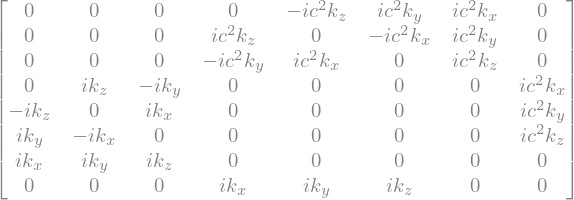

In [6]:
fields_list = [Ex, Ey, Ez, Bx, By, Bz]
if divE_cleaning:
    fields_list.append(F)
if divB_cleaning:
    fields_list.append(G)

EBFG = zeros(dim, 1)
for i in range(EBFG.shape[0]):
    EBFG[i] = fields_list[i]

fields_list = [dEx_dt, dEy_dt, dEz_dt, dBx_dt, dBy_dt, dBz_dt]
if divE_cleaning:
    fields_list.append(dF_dt)
if divB_cleaning:
    fields_list.append(dG_dt)

dEBFG_dt = zeros(dim, 1)
for i in range(dEBFG_dt.shape[0]):
    dEBFG_dt[i] = fields_list[i]
dEBFG_dt = dEBFG_dt.expand()

M = zeros(dim)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        M[i,j] = dEBFG_dt[i].coeff(EBFG[j], 1)
print(r'M = ')
display(M)

### Diagonalization of $W_1 = M (t-t_n) = P_1 D_1 P_1^{-1}$:

P1 = 


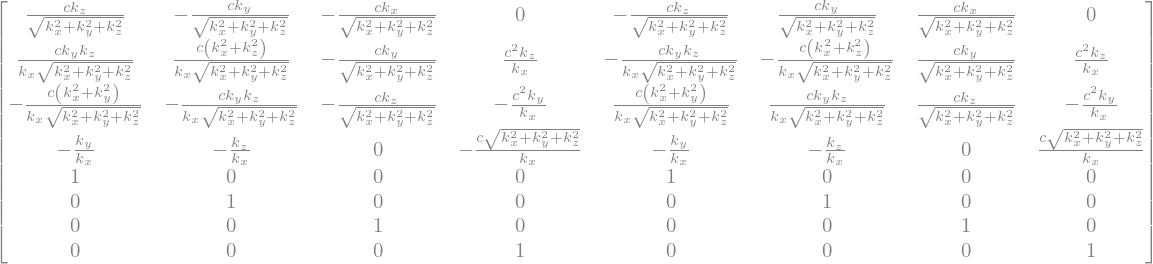

D1 = 


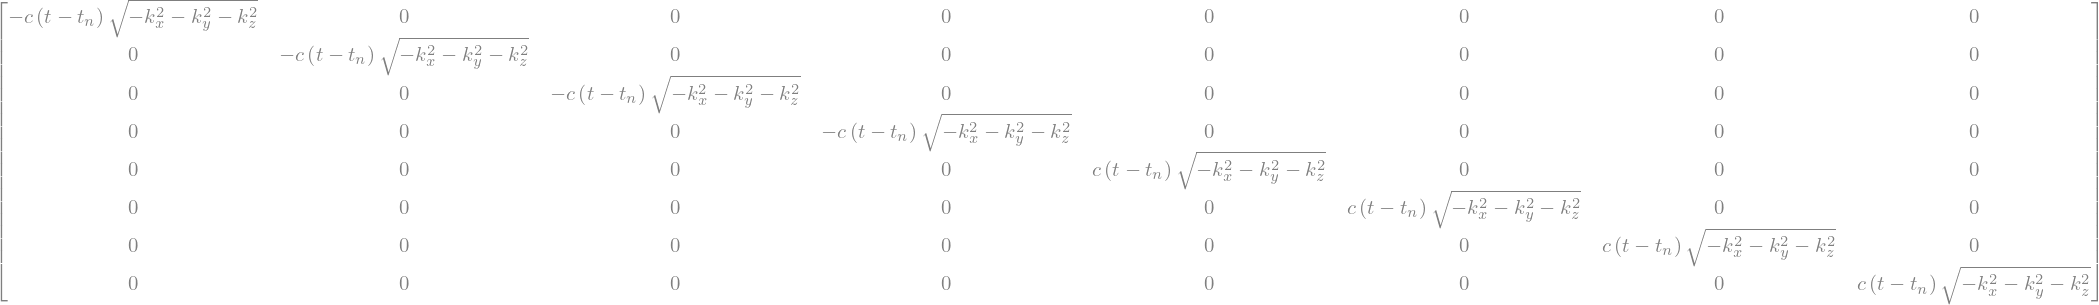

CPU times: user 54.2 s, sys: 27.4 ms, total: 54.2 s
Wall time: 54.7 s


In [7]:
%%time

W1 = M * (t-tn)
P1, D1 = W1.diagonalize()
invP1 = P1**(-1)
expD1 = exp(D1)
check_diag(W1, D1, P1, invP1)
print('P1 = ')
display(P1)
print('D1 = ')
display(D1)

### Diagonalization of $W_2 = M t = P_2 D_2 P_2^{-1}$:

P2 = 


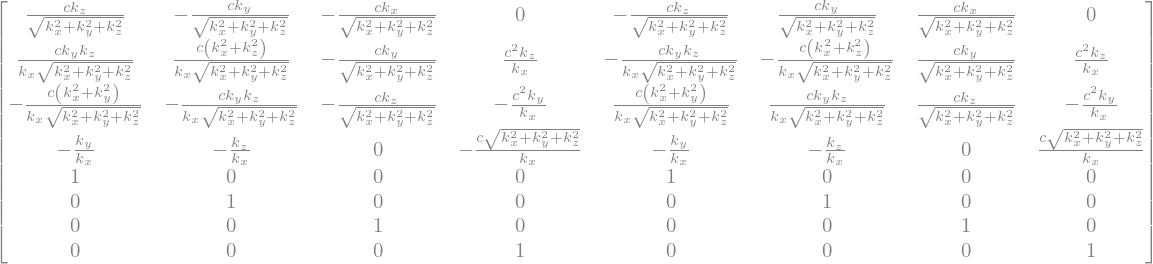

D2 = 


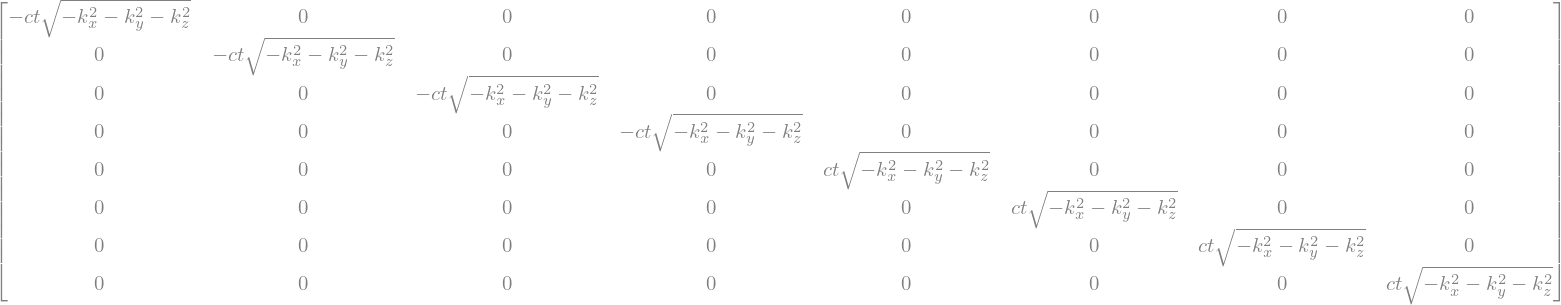

CPU times: user 28 s, sys: 31.8 ms, total: 28.1 s
Wall time: 28.5 s


In [8]:
%%time

W2 = M * t
P2, D2 = W2.diagonalize()
invP2 = P2**(-1)
expD2 = exp(D2)
check_diag(W2, D2, P2, invP2)
print('P2 = ')
display(P2)
print('D2 = ')
display(D2)

### Diagonalization of $W_3 = -M s = P_3 D_3 P_3^{-1}$:

P3 = 


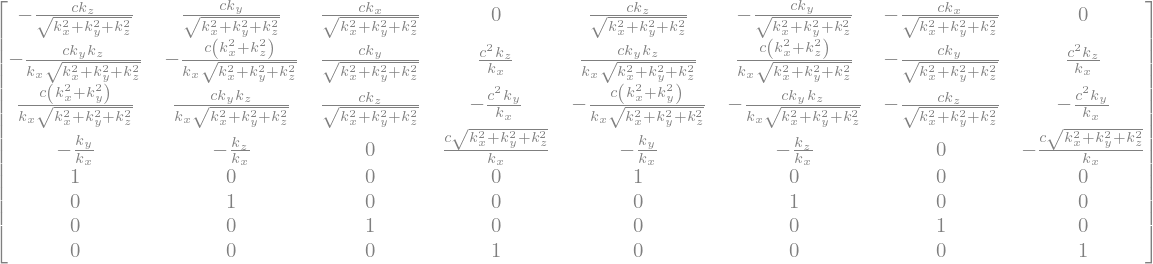

D3 = 


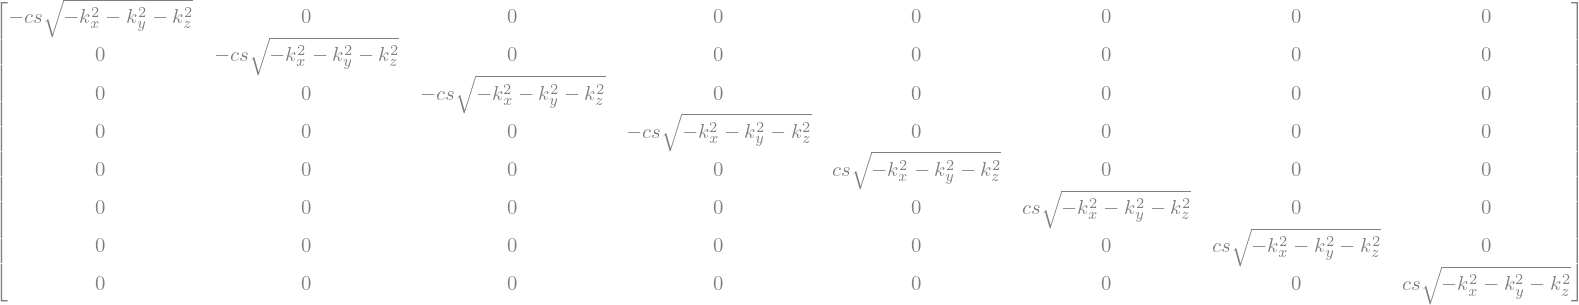

CPU times: user 34 s, sys: 36 ms, total: 34 s
Wall time: 34.4 s


In [9]:
%%time

W3 = (-1) * M * s
P3, D3 = W3.diagonalize()
invP3 = P3**(-1)
expD3 = exp(D3)
check_diag(W3, D3, P3, invP3)
print('P3 = ')
display(P3)
print('D3 = ')
display(D3)

### General solution (homogeneous system):
$$
\begin{bmatrix}
\boldsymbol{E}_h(t) \\
\boldsymbol{B}_h(t) \\
F_h(t) \\
G_h(t)
\end{bmatrix}
= e^{M (t-t_n)}
\begin{bmatrix}
\boldsymbol{E}(t_n) \\
\boldsymbol{B}(t_n) \\
F(t_n) \\
G(t_n)
\end{bmatrix}
$$

In [10]:
%%time

# Compute exp(W1) = exp(M*(t-tn))
expW1 = P1 * expD1 * invP1

# Compute general solution at time t = tn+dt
EBFG_h = expW1 * EBFG
EBFG_h = EBFG_h.subs(t, tn+dt)

CPU times: user 146 ms, sys: 4 ms, total: 150 ms
Wall time: 148 ms


Coefficient of Ex with respect to Ex:


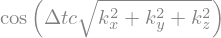

Coefficient of Ex with respect to Ey:


Coefficient of Ex with respect to Ez:


Coefficient of Ex with respect to Bx:


Coefficient of Ex with respect to By:


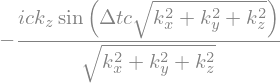

Coefficient of Ex with respect to Bz:


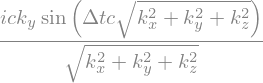

Coefficient of Ex with respect to F:


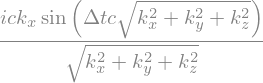

Coefficient of Ex with respect to G:


Coefficient of Ey with respect to Ex:


Coefficient of Ey with respect to Ey:


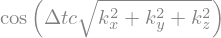

Coefficient of Ey with respect to Ez:


Coefficient of Ey with respect to Bx:


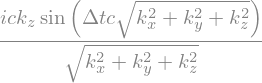

Coefficient of Ey with respect to By:


Coefficient of Ey with respect to Bz:


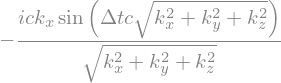

Coefficient of Ey with respect to F:


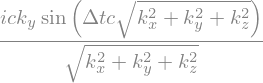

Coefficient of Ey with respect to G:


Coefficient of Ez with respect to Ex:


Coefficient of Ez with respect to Ey:


Coefficient of Ez with respect to Ez:


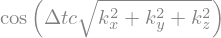

Coefficient of Ez with respect to Bx:


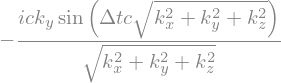

Coefficient of Ez with respect to By:


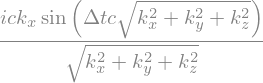

Coefficient of Ez with respect to Bz:


Coefficient of Ez with respect to F:


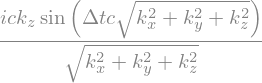

Coefficient of Ez with respect to G:


Coefficient of Bx with respect to Ex:


Coefficient of Bx with respect to Ey:


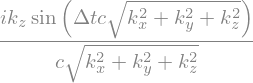

Coefficient of Bx with respect to Ez:


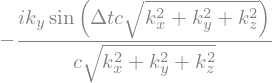

Coefficient of Bx with respect to Bx:


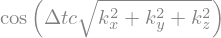

Coefficient of Bx with respect to By:


Coefficient of Bx with respect to Bz:


Coefficient of Bx with respect to F:


Coefficient of Bx with respect to G:


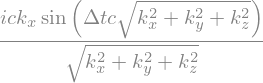

Coefficient of By with respect to Ex:


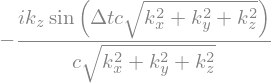

Coefficient of By with respect to Ey:


Coefficient of By with respect to Ez:


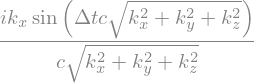

Coefficient of By with respect to Bx:


Coefficient of By with respect to By:


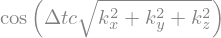

Coefficient of By with respect to Bz:


Coefficient of By with respect to F:


Coefficient of By with respect to G:


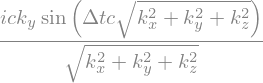

Coefficient of Bz with respect to Ex:


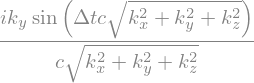

Coefficient of Bz with respect to Ey:


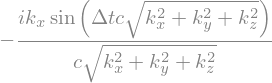

Coefficient of Bz with respect to Ez:


Coefficient of Bz with respect to Bx:


Coefficient of Bz with respect to By:


Coefficient of Bz with respect to Bz:


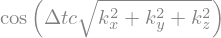

Coefficient of Bz with respect to F:


Coefficient of Bz with respect to G:


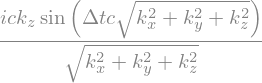

Coefficient of F with respect to Ex:


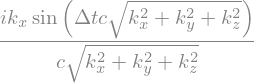

Coefficient of F with respect to Ey:


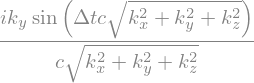

Coefficient of F with respect to Ez:


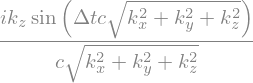

Coefficient of F with respect to Bx:


Coefficient of F with respect to By:


Coefficient of F with respect to Bz:


Coefficient of F with respect to F:


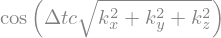

Coefficient of F with respect to G:


Coefficient of G with respect to Ex:


Coefficient of G with respect to Ey:


Coefficient of G with respect to Ez:


Coefficient of G with respect to Bx:


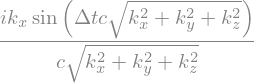

Coefficient of G with respect to By:


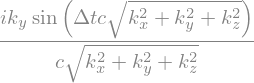

Coefficient of G with respect to Bz:


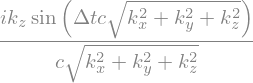

Coefficient of G with respect to F:


Coefficient of G with respect to G:


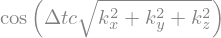

CPU times: user 4.46 s, sys: 816 ms, total: 5.28 s
Wall time: 18.5 s


In [11]:
%%time

L = ['Ex', 'Ey', 'Ez', 'Bx', 'By', 'Bz']
R = ['Ex', 'Ey', 'Ez', 'Bx', 'By', 'Bz']
if divE_cleaning:
    L.append('F')
    R.append('F')
if divB_cleaning:
    L.append('G')
    R.append('G')

# Compute individual coefficients in update equation
coeff_h = dict()
for i in range(dim):
    for j in range(dim):
        key = (L[i], R[j])
        coeff_h[key] = EBFG_h[i].coeff(EBFG[j], 1).expand().simplify().rewrite(cos).trigsimp().simplify()
        print(f'Coefficient of {L[i]} with respect to {R[j]}:')
        display(coeff_h[key])

### Definition of $\boldsymbol{J}(t)$ and $\rho(t)$:

In [12]:
# Define J(t)
Jx_c0 = sp.symbols(r'\gamma_{J_x}', real=True)
Jy_c0 = sp.symbols(r'\gamma_{J_y}', real=True)
Jz_c0 = sp.symbols(r'\gamma_{J_z}', real=True)
Jx = Jx_c0
Jy = Jy_c0
Jz = Jz_c0
if J_in_time == 'linear':
    Jx_c1 = sp.symbols(r'\beta_{J_x}', real=True)
    Jy_c1 = sp.symbols(r'\beta_{J_y}', real=True)
    Jz_c1 = sp.symbols(r'\beta_{J_z}', real=True)
    Jx += Jx_c1*(s-tn)
    Jy += Jy_c1*(s-tn)
    Jz += Jz_c1*(s-tn)
if J_in_time == 'quadratic':
    Jx_c1 = sp.symbols(r'\beta_{J_x}', real=True)
    Jy_c1 = sp.symbols(r'\beta_{J_y}', real=True)
    Jz_c1 = sp.symbols(r'\beta_{J_z}', real=True)
    Jx_c2 = sp.symbols(r'\alpha_{J_x}', real=True)
    Jy_c2 = sp.symbols(r'\alpha_{J_y}', real=True)
    Jz_c2 = sp.symbols(r'\alpha_{J_z}', real=True)
    Jx += Jx_c1*(s-tn) + Jx_c2*(s-tn)**2
    Jy += Jy_c1*(s-tn) + Jy_c2*(s-tn)**2
    Jz += Jz_c1*(s-tn) + Jz_c2*(s-tn)**2

# Define rho(t)
if divE_cleaning:
    rho_c0 = sp.symbols(r'\gamma_{\rho}', real=True)
    rho = rho_c0
    if rho_in_time == 'linear':
        rho_c1 = sp.symbols(r'\beta_{\rho}', real=True)
        rho += rho_c1*(s-tn)
    if rho_in_time == 'quadratic':
        rho_c1 = sp.symbols(r'\beta_{\rho}', real=True)
        rho_c2 = sp.symbols(r'\alpha_{\rho}', real=True)
        rho += rho_c1*(s-tn) + rho_c2*(s-tn)**2

### Particular solution (non-homogeneous system):
$$
\begin{bmatrix}
\boldsymbol{E}_{nh}(t) \\
\boldsymbol{B}_{nh}(t) \\
F_{nh}(t) \\
G_{nh}(t)
\end{bmatrix}
= -\mu_0 c^2 e^{M t} \left(\int_{t_n}^t e^{-M s}
\begin{bmatrix}
\boldsymbol{J} \\
\boldsymbol{0} \\
\rho \\
0
\end{bmatrix}
ds\right)
$$

In [13]:
%%time 
        
fields_list = [Jx, Jy, Jz, 0, 0, 0]
if divE_cleaning:
    fields_list.append(rho)
if divB_cleaning:
    fields_list.append(0)

S = zeros(dim, 1)
for i in range(S.shape[0]):
    S[i] = -mu0*c**2 * fields_list[i]

# Compute integral of exp(W3)*S over s (assuming |k| is not zero)
integral = zeros(dim, 1)
tmp = expD3 * invP3 * S
simple_mat(tmp)
for i in range(dim):
    r = integrate(tmp[i], (s, tn, t))
    integral[i] = r.simplify()
    
# Compute particular solution at time t = tn+dt
tmp = invP2 * P3
simple_mat(tmp)
EBFG_nh = P2 * expD2 * tmp * integral
EBFG_nh = EBFG_nh.subs(t, tn+dt)

CPU times: user 7.57 s, sys: 16 ms, total: 7.59 s
Wall time: 7.59 s


Coefficient of Ex with respect to Jx_c0:


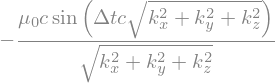

Coefficient of Ex with respect to Jy_c0:


Coefficient of Ex with respect to Jz_c0:


Coefficient of Ex with respect to rho_c0:


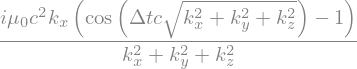

Coefficient of Ey with respect to Jx_c0:


Coefficient of Ey with respect to Jy_c0:


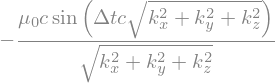

Coefficient of Ey with respect to Jz_c0:


Coefficient of Ey with respect to rho_c0:


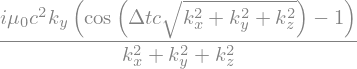

Coefficient of Ez with respect to Jx_c0:


Coefficient of Ez with respect to Jy_c0:


Coefficient of Ez with respect to Jz_c0:


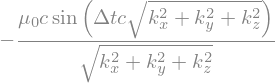

Coefficient of Ez with respect to rho_c0:


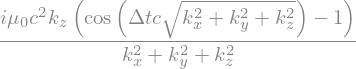

Coefficient of Bx with respect to Jx_c0:


Coefficient of Bx with respect to Jy_c0:


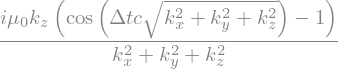

Coefficient of Bx with respect to Jz_c0:


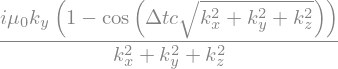

Coefficient of Bx with respect to rho_c0:


Coefficient of By with respect to Jx_c0:


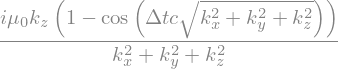

Coefficient of By with respect to Jy_c0:


Coefficient of By with respect to Jz_c0:


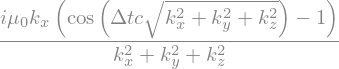

Coefficient of By with respect to rho_c0:


Coefficient of Bz with respect to Jx_c0:


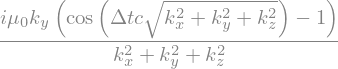

Coefficient of Bz with respect to Jy_c0:


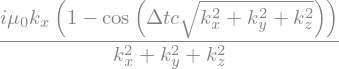

Coefficient of Bz with respect to Jz_c0:


Coefficient of Bz with respect to rho_c0:


Coefficient of F with respect to Jx_c0:


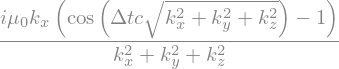

Coefficient of F with respect to Jy_c0:


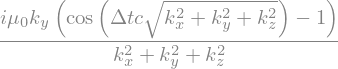

Coefficient of F with respect to Jz_c0:


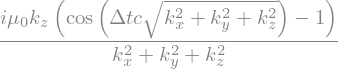

Coefficient of F with respect to rho_c0:


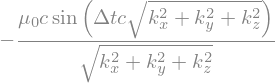

Coefficient of G with respect to Jx_c0:


Coefficient of G with respect to Jy_c0:


Coefficient of G with respect to Jz_c0:


Coefficient of G with respect to rho_c0:


CPU times: user 14.1 s, sys: 380 ms, total: 14.5 s
Wall time: 21.1 s


In [14]:
%%time

L = ['Ex', 'Ey', 'Ez', 'Bx', 'By', 'Bz']
R = ['Jx_c0', 'Jy_c0', 'Jz_c0']
if J_in_time == 'linear':
    R.append('Jx_c1')
    R.append('Jy_c1')
    R.append('Jz_c1')
if J_in_time == 'quadratic':
    R.append('Jx_c1')
    R.append('Jy_c1')
    R.append('Jz_c1')
    R.append('Jx_c2')
    R.append('Jy_c2')
    R.append('Jz_c2')
if divE_cleaning:
    L.append('F')
    R.append('rho_c0')
    if rho_in_time == 'linear':
        R.append('rho_c1')
    if rho_in_time == 'quadratic':
        R.append('rho_c1')
        R.append('rho_c2')
if divB_cleaning:
    L.append('G')

ab = [Jx_c0, Jy_c0, Jz_c0]
if J_in_time == 'linear':
    ab.append(Jx_c1)
    ab.append(Jy_c1)
    ab.append(Jz_c1)
if J_in_time == 'quadratic':
    ab.append(Jx_c1)
    ab.append(Jy_c1)
    ab.append(Jz_c1)
    ab.append(Jx_c2)
    ab.append(Jy_c2)
    ab.append(Jz_c2)
if divE_cleaning:
    ab.append(rho_c0)
    if rho_in_time == 'linear':
        ab.append(rho_c1)
    if rho_in_time == 'quadratic':
        ab.append(rho_c1)
        ab.append(rho_c2)
    
# Compute individual coefficients in update equation
coeff_nh = dict()
for i in range(len(L)):
    for j in range(len(R)):
        key = (L[i], R[j])
        coeff_nh[key] = EBFG_nh[i].expand().coeff(ab[j], 1).expand().simplify().rewrite(cos).trigsimp().simplify()
        print(f'Coefficient of {L[i]} with respect to {R[j]}:')
        display(coeff_nh[key])

### Coefficients of update equations:

Display the coefficients of the update equations, for example:
- `coeff_h[('Ex', 'By')]`, for the homogeneous solution
- `coeff_nh[('Ex', 'Jx_c0')]`, for the non-homogeneous solution

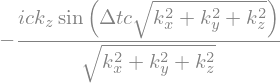

In [15]:
coeff_h[('Ex', 'By')]

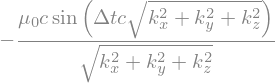

In [16]:
coeff_nh[('Ex', 'Jx_c0')]